### 1. 기본 설정

- 라이브러리

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

- 불러오기 (전처리 후)

In [13]:
file_path = '../전처리 완료/lendingclub 전처리 완료.csv' 

# 파일이 있는지 확인하고 로드
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print("파일이 없습니다")

display(df.head())

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,loan_status,purpose,dti,delinq_2yrs,fico_range_low,pub_rec,revol_util
0,3600.0,36 months,13.99,C,MORTGAGE,55000.0,Fully Paid,debt_consolidation,5.91,0.0,675.0,0.0,29.7
1,24700.0,36 months,11.99,C,MORTGAGE,65000.0,Fully Paid,small_business,16.06,1.0,715.0,0.0,19.2
2,20000.0,60 months,10.78,B,MORTGAGE,63000.0,Fully Paid,home_improvement,10.78,0.0,695.0,0.0,56.2
3,35000.0,60 months,14.85,C,MORTGAGE,110000.0,Current,debt_consolidation,17.06,0.0,785.0,0.0,11.6
4,10400.0,60 months,22.45,F,MORTGAGE,104433.0,Fully Paid,major_purchase,25.37,1.0,695.0,0.0,64.5


- 한글 폰트 깨짐 방지

In [14]:
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') 
else:
    # 리눅스
    plt.rc('font', family='NanumGothic')

# 마이너스 기호방지
plt.rcParams['axes.unicode_minus'] = False

- 결측치 확인

In [15]:
info = df.isnull().sum()
cols = info[info > 0]

if len(cols) > 0:
    print(cols)
    display(df[df.isnull().any(axis=1)])

else:
    print('결측치 없음')

결측치 없음


### 2. EDA 

#### 1. 피처 엔지니어링 

1. loan_status_binary : 이진위로 분류 (라벨 인코딩)

- fully paid(정상 상환) = 0
- charged off(부실/연체) = 1

In [16]:
df['loan_status']

0           Fully Paid
1           Fully Paid
2           Fully Paid
3              Current
4           Fully Paid
              ...     
2257147        Current
2257148        Current
2257149        Current
2257150    Charged Off
2257151        Current
Name: loan_status, Length: 2257152, dtype: object

In [17]:
# 1. loan_status_binary
target_status = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(target_status)]

loan_status_mapping = {
    'Fully Paid': 0,
    'Charged Off': 1
}

df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)

df['loan_status_binary']

0          0
1          0
2          0
4          0
5          0
          ..
2257141    0
2257143    0
2257144    1
2257145    0
2257150    1
Name: loan_status_binary, Length: 1344075, dtype: int64

2. LTI : 내 연봉 대비 대출금이 얼마인가? (대출금 / 연소득) (파생변수)

In [19]:
# 2. LTI (Loan to Income)
# 공식: 대출금액 / 연소득
df['LTI'] = df['loan_amnt'] / df['annual_inc']
df['LTI']

0          0.065455
1          0.380000
2          0.317460
4          0.099585
5          0.351471
             ...   
2257141    0.138462
2257143    0.162618
2257144    0.203822
2257145    0.106667
2257150    0.218182
Name: LTI, Length: 1344075, dtype: float64

3. 등급 수치화: A는 1등급, G는 7등급 (숫자가 클수록 위험) ---> 라벨 인코딩 

In [20]:
df['grade']

0          C
1          C
2          B
4          F
5          C
          ..
2257141    B
2257143    C
2257144    C
2257145    C
2257150    C
Name: grade, Length: 1344075, dtype: object

In [21]:
# 3. 등급 수치화 -->  알파벳 등급을 점수로
# A(우량) = 1점 ~ G(위험) = 7점 (숫자가 클수록 위험함)
grade_dic = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade_num'] = df['grade'].map(grade_dic)

df['grade_num']

0          3
1          3
2          2
4          6
5          3
          ..
2257141    2
2257143    3
2257144    3
2257145    3
2257150    3
Name: grade_num, Length: 1344075, dtype: int64

4. term 컬럼에서 '36개월 이상' 같은 문자열을 36이라는 숫자열로 변환하고 이름은 그대로사용 --> 전처리

In [22]:
df['term']

0           36 months
1           36 months
2           60 months
4           60 months
5           36 months
              ...    
2257141     60 months
2257143     60 months
2257144     60 months
2257145     60 months
2257150     60 months
Name: term, Length: 1344075, dtype: object

In [23]:
# 4. term -> int
# 앞뒤 공백 제거
df['term'] = df['term'].str.strip()
df['term'].unique()

# 'months' 제거 후 숫자로 변환
df['term_num'] = df['term'].str.replace(' months', '').astype(int)
df['term_num'].unique()

df['term_num']

0          36
1          36
2          60
4          60
5          36
           ..
2257141    60
2257143    60
2257144    60
2257145    60
2257150    60
Name: term_num, Length: 1344075, dtype: int64

5. home_ownership: ('MORTGAGE',  'OWN' 소유:0), ('ANY', 'RENT' ,'NONE', 'OTHER' 미소유:1) --> 라벨 인코딩

In [ ]:
df['home_ownership']

0          MORTGAGE
1          MORTGAGE
2          MORTGAGE
4          MORTGAGE
5              RENT
             ...   
2257141         OWN
2257143    MORTGAGE
2257144    MORTGAGE
2257145        RENT
2257150        RENT
Name: home_ownership, Length: 1344075, dtype: object

In [25]:
map_home_ownership = {
    'MORTGAGE': 0, 'OWN':0, 'ANY':1, 'RENT': 1, 'NONE': 1, 
    'OTHER' : 1
}
map_home_ownership = df['home_ownership'].map(map_home_ownership)
df['map_home_ownership']=map_home_ownership

df['map_home_ownership']

0          0
1          0
2          0
4          0
5          1
          ..
2257141    0
2257143    0
2257144    0
2257145    1
2257150    1
Name: map_home_ownership, Length: 1344075, dtype: int64

- 파생변수 생성 확인

In [26]:
# 확인
df[['loan_status_binary', 'LTI', 'grade_num', 'term_num', 'map_home_ownership']].head(3)

,loan_status_binary,LTI,grade_num,term_num,map_home_ownership
0,0,0.065455,3,36,0
1,0,0.380000,3,36,0
2,0,0.317460,2,60,0


#### 2. 분석 / 시각화

- 종속변수 (loan_status_binary) 

완납한 사람 (Fully Paid) VS 미납한 사람(Charged Off)의 비율

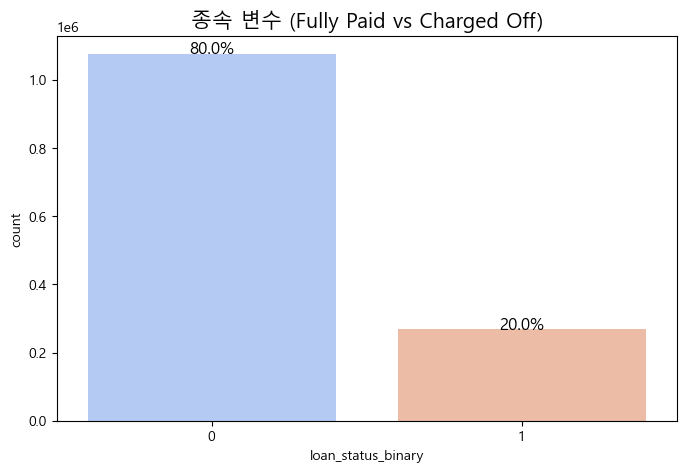

In [27]:
plt.figure(figsize=(8, 5))

# 카운트플롯 사용
ax = sns.countplot(x='loan_status_binary', data=df, palette='coolwarm')

# 그래프 위에 비율 표시하는 방법
total = len(df) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1000, 
            f'{height/total:.1%}', ha="center", fontsize=12)

plt.title('종속 변수 (Fully Paid vs Charged Off)', fontsize=15)
plt.show()

##### 1. [원본 변수] 수치형 데이터 분석

2. 부채 상환 비율 (dti): 빚이 이미 많은 사람이 또 빌렸을 때 부도가 날까?   ----> 큰 차이는 아니지만 부채가 많은 사람이 채무를 이행하지 않을 가능성이 조금 더 높음


4. 대출금액 (loan_amnt): 큰돈을 빌린 사람이 갚기 더 힘들었을까? ----> 역시나 두 그룹간의 차이가 크게 있지않는다 / 대출을 많이 빌렸다고 해서 부도 확률이 눈에 띄게 높아지는 것은 아님

5. 리볼빙 사용률 (revol_util): 카드 한도를 꽉 채워 쓰는 사람이 위험할까?

1. 이자율 (int_rate): 부도난 사람들은 애초에 고금리 대출자였을까?  ----> 이자가 높을수록 디폴트 확률이 높아짐

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(5.308999999999999, 7.39]'),
  Text(1, 0, '(7.39, 8.9]'),
  Text(2, 0, '(8.9, 10.49]'),
  Text(3, 0, '(10.49, 11.53]'),
  Text(4, 0, '(11.53, 12.74]'),
  Text(5, 0, '(12.74, 13.98]'),
  Text(6, 0, '(13.98, 15.22]'),
  Text(7, 0, '(15.22, 16.99]'),
  Text(8, 0, '(16.99, 19.48]'),
  Text(9, 0, '(19.48, 30.99]')])

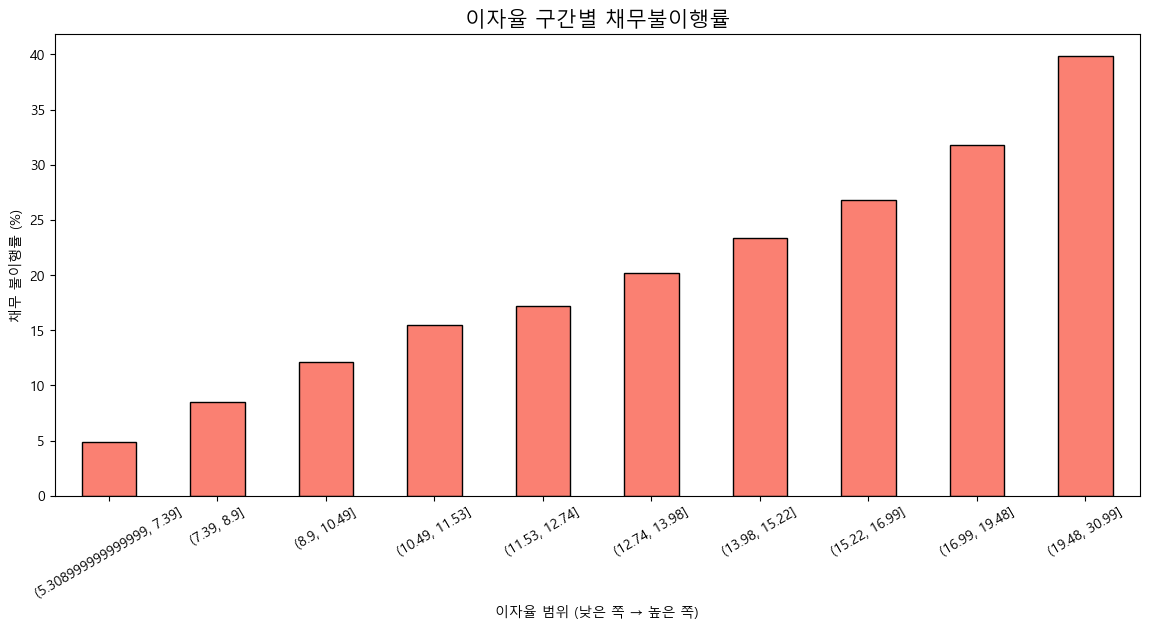

In [ ]:
df['int_bin'] = pd.qcut(df['int_rate'], 10) # 10분위수로
int = df.groupby('int_bin')['loan_status_binary'].mean() * 100 # 비율 계ㅆ산

plt.figure(figsize=(14, 6))
int.plot(kind='bar', color='salmon', edgecolor='black')

plt.title('이자율 구간별 대출 완/미납률', fontsize=15)
plt.xlabel('이자율 범위 (낮은 쪽 → 높은 쪽)')
plt.ylabel('채무 불이행률 (%)')
plt.xticks(rotation=30)

- 바차트 위에 % 출력

- 각 막대 별로 차지하고 있는 건수가 몇건인지


2. 연소득 (annual_inc): 돈을 못 버는 사람이 디폴트 가능성이 더 높을까?  ----> 두 그릅간의 큰 차이는 없었다 / 돈을 많이 번다고 해서 반드시 돈을 잘 갚는 것은 아님

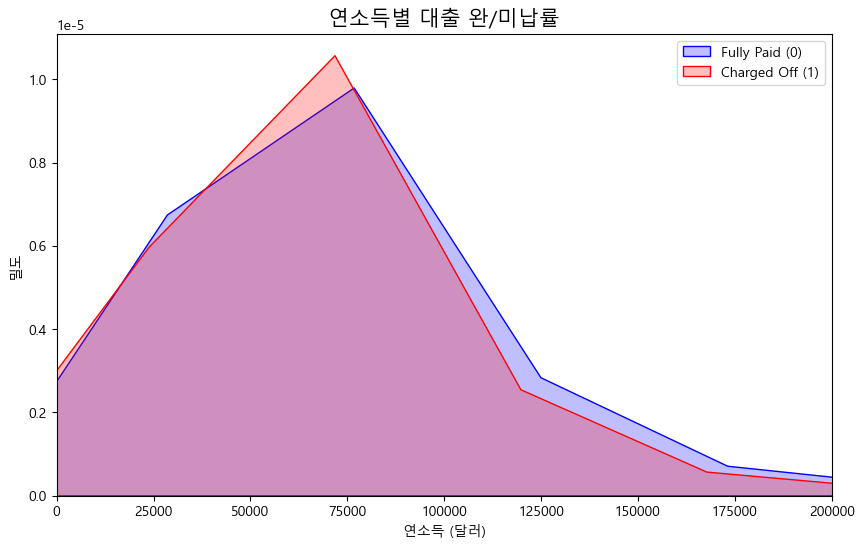

In [61]:
plt.figure(figsize=(10, 6))

# Fully_Paid 0 
sns.kdeplot(df[df['loan_status_binary'] == 0]['annual_inc'], 
            label='Fully Paid (0)', shade=True, color='blue', bw_adjust=1.5)
# Charged Off 1
sns.kdeplot(df[df['loan_status_binary'] == 1]['annual_inc'], 
            label='Charged Off (1)', shade=True, color='red', bw_adjust=1.5)

plt.title('연소득별 대출 완/미납률', fontsize=15)
plt.xlabel('연소득 (달러)')
plt.ylabel('밀도')
plt.xlim(0, 200000) # 상위구간이 너무 높아 보이지않음 --> 연봉 1000만에서 200만으로 줄임
plt.legend()
plt.show()

- 박스 플롯

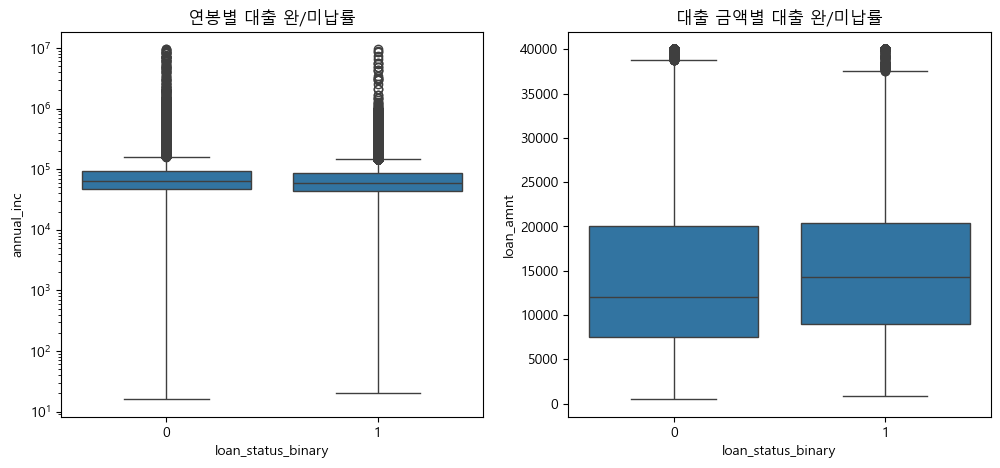

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='loan_status_binary', y='annual_inc', data=df)
plt.yscale('log') 
plt.title('연봉별 대출 완/미납률')

plt.subplot(1, 2, 2)
sns.boxplot(x='loan_status_binary', y='loan_amnt', data=df)
plt.title('대출 금액별 대출 완/미납률')

plt.show()

자른 기준 명확하게 

- 파생 변수 (LTI) (KDE 그래프)

- 연 소득이나 대출금액은 예상했던 것과 달리 큰 차이점을 보이지 못함 

- 그래서 만든 파생 변수 소득 대비 대출액(LTI)은 커질수록 부도 위험군의 분포가 오른쪽(높은 쪽)으로 이동하는 것을 확인할 수 있음

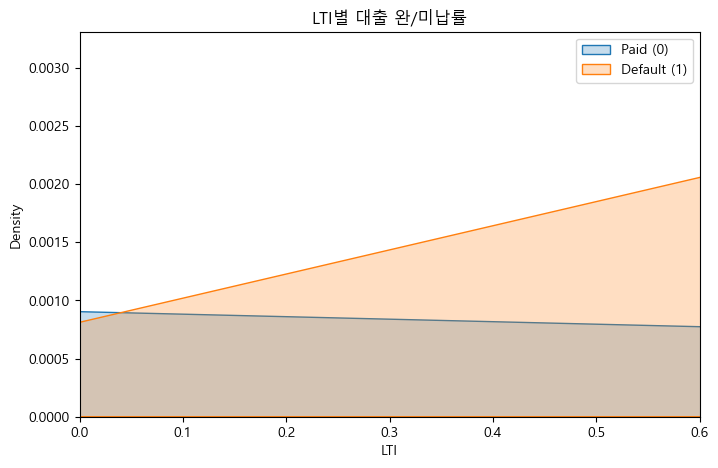

In [ ]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['loan_status_binary']==0]['LTI'], label='Paid (0)', shade=True)
sns.kdeplot(df[df['loan_status_binary']==1]['LTI'], label='Default (1)', shade=True)
plt.xlim(0, 0.6) 
plt.title('LTI별 대출 완/미납률')
plt.legend()
plt.show()

1. 연봉에 따른 대출 상환여부

2. LTI에 따른 대출 상환여부 LTI (대출 / 연소득)

3. 대출금에 따른 대출 완/미납율도 확인

3. 리볼빙 사용률 (revol_util) 구간별 미상환률

- 카드 한도를 얼마나 썼는지가 부도에 미치는 영향을 보여줌

- 리볼빙 사용률이 높을수록(한도에 가까울수록) 부도율이 서서히 상승하는 모습

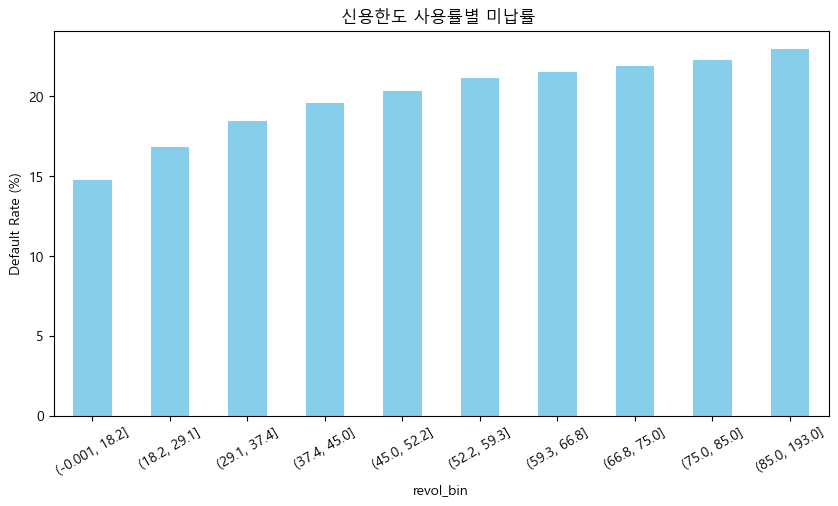

In [ ]:
df['revol_bin'] = pd.qcut(df['revol_util'], 10)  # 10분위수로 나누기
revol_risk = df.groupby('revol_bin')['loan_status_binary'].mean() * 100

revol_risk.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('신용한도 사용률별 미납률 ')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=30)
plt.show() 

4. 신용 등급(Grade)별 대출 미상환률

- 기존 신용 등급이 디폴트 가능성에 대해 얼마나 큰 영향력이 있는지 보여줌
|
- 등급이 낮아질수록 부도율이 기하급수적으로 증가하며, 특히 E~G 등급은 매우 높은 위험도를 나타냄

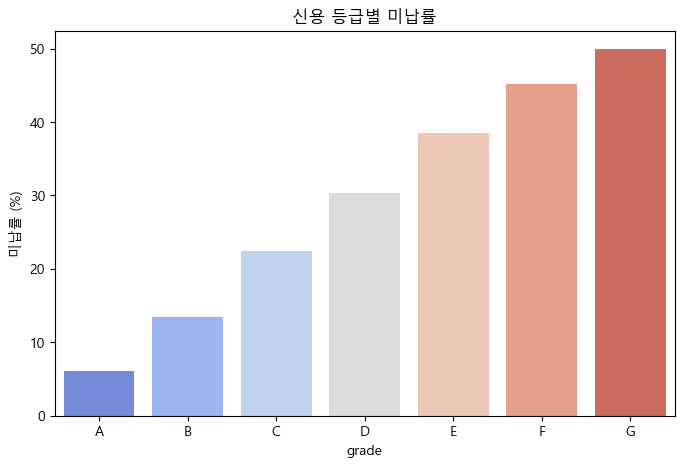

In [42]:
grade_risk = df.groupby('grade')['loan_status_binary'].mean().sort_index() * 100

plt.figure(figsize=(8, 5))
sns.barplot(x=grade_risk.index, y=grade_risk.values, palette='coolwarm')
plt.title('신용 등급별 미납률')
plt.ylabel('미납률 (%)')
plt.show()

5. 주거 형태별 부도율

- 0(자가/모기지)과 1(임대)의 차이를 보여줌

- 임대 거주자가 주택 소유자(자가/모기지 포함)보다 통계적으로 높은 부도율을 기록하여, 거주 안정성이 상환 의지에 영향을 미침을 알 수 있음

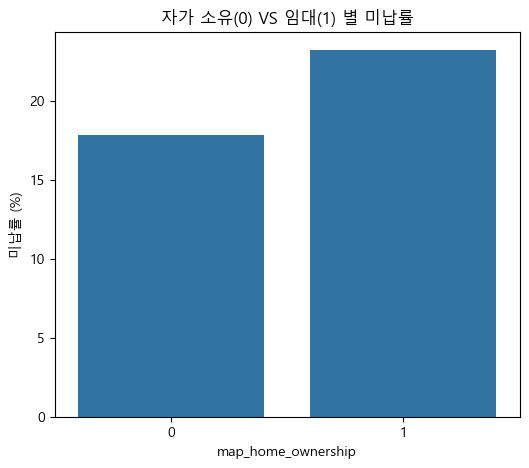

In [46]:
home_risk = df.groupby('map_home_ownership')['loan_status_binary'].mean() * 100

plt.figure(figsize=(6, 5))
sns.barplot(x=home_risk.index, y=home_risk.values)
plt.title('자가 소유(0) VS 임대(1) 별 미납률')
plt.ylabel('미납률 (%)')
plt.show()

##### 2. [원본 변수] 범주형 데이터 분석

- 그룹별 부도율 비교

1. 대출 목적 (purpose): '결혼 자금' vs '사업 자금' vs '빚 갚기', 어디서 부도가 많이 날까?

2. 주거 형태 (map_home_ownership): 0(자가/모기지) vs 1(임대 등등)

3. 대출 기간 (term_num): 36개월 vs 60개월

4. 등급별 부도율

In [ ]:
# purpose 
df['purpose'].unique()

array(['debt_consolidation', 'small_business', 'home_improvement',
       'major_purchase', 'credit_card', 'other', 'house', 'vacation',
       'car', 'medical', 'moving', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

##### 3. [파생 변수]

- LTI(연봉대비 대출금) 별 평균 채무불이행률

미상환 그룹(1)의 LTI가 정상 상환자 그룹(0)보다 약 20%나 더 높다 (0.04 / 0.21 ≒ 19.7%)

In [27]:
print(df.groupby('loan_status_binary')['LTI'].mean())

loan_status_binary
0    0.210297
1    0.251801
Name: LTI, dtype: float64


- 바플롯으로 시각화

In [ ]:
['LTI_bin'] = pd.qcut(df['LTI'], 10) # 분위수 10개로 나누기

lti = df.groupby('LTI_bin')['loan_status_binary'].mean() * 100 # 구간별 부도율
  
plt.figure(figsize=(12, 6))
lti.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('(LTI) 별 채무뷸이행률(%)', fontsize=15)  # 대출/연봉별 (LTI) 채무불이행률 
plt.xlabel('LTI 범위')
plt.ylabel('채무불이행률 (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 비율 표시를 하는방법 --> for문으로 enumerate 각각 컬럼에 0.5씩 더하고 f'{인덱스:.1f}%' 
for i, v in enumerate(lti):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')
 
plt.show()

- 결론 

LTI (소득대비 부채비율)별 채무뷸이행률 계산해보니 우상향 하는 그래프가 나타남

---> 소득대비 부채비율이이 높을수록 디폴트할 가능성이 수직상승함

### 3. 통계 검정

1. LTI(소득 대비 대출 비중)는 부도 여부를 가르는 유효한 지표인가?

- 분석 종류 : 독립표본 T-검정 (Independent T-test)

- 귀무가설($H_0$): 상환자 그룹과 부도자 그룹의 평균 LTI 차이는 없다.

-  대립가설($H_1$): 부도자 그룹의 평균 LTI가 상환자 그룹보다 통계적으로 유의미하게 높을 것이다.

In [62]:
from scipy import stats

lti_paid = df[df['loan_status_binary'] == 0]['LTI'].dropna()
lti_default = df[df['loan_status_binary'] == 1]['LTI'].dropna() # 결측치가 있을 가능성으로 dropna()

# T-검정 
t_stat, p_val = stats.ttest_ind(lti_paid, lti_default, equal_var=False)

print(f"T_stat: {t_stat:.4f}")
print(f"p_value: {p_val:.10f}")

alpha = 0.05 
if p_val < alpha:
    print(f"\n[ 귀무가설 기각 / 대립가설 채택]")
    print("상환자와 부도자 그룹 간의 LTI 평균 차이는 통계적으로 매우 유의미하다")
    print("즉, LTI는 부도 여부를 결정짓는 핵심적인 지표임이 입증")
else:
    print(f"\n[ 귀무가설 채택 / 대립가설 기각 ]")
    print("두 그룹 간의 LTI 차이는 통계적으로 유의미하지 않다, (우연일 가능성 높음)")

T_stat: -23.6294
p_value: 0.0000000000

[ 귀무가설 기각 / 대립가설 채택]
상환자와 부도자 그룹 간의 LTI 평균 차이는 통계적으로 매우 유의미하다
즉, LTI는 부도 여부를 결정짓는 핵심적인 지표임이 입증


2. 리볼빙 사용률(revol_util)이 높을수록 부도 위험이 커지는가?

- 분석 종류: 독립표본 T-검정 (Independent T-test)

- 귀무가설($H_0$): 상환자 그룹과 부도자 그룹의 평균 리볼빙 사용률 차이는 없다.

- 대립가설($H_1$): 부도자 그룹의 리볼빙 사용률이 상환자 그룹보다 통계적으로 유의미하게 높을 것이다

In [ ]:
revol_paid = df[df['loan_status_binary'] == 0]['revol_util'].dropna()
revol_default = df[df['loan_status_binary'] == 1]['revol_util'].dropna()

# T-검정 
t_stat_revol, p_val_revol = stats.ttest_ind(revol_paid, revol_default, equal_var=False)
print(f"T-stat: {t_stat_revol:.4f}")
print(f"p-value: {p_val_revol:.10f}")

alpha = 0.05
if p_val_revol < alpha:
    print(f"\n[ 귀무가설(H0) 기각 / 대립가설 채택 ]")
    print("두 그룹 간의 리볼빙 사용률 차이는 '통계적으로 유의미'하다.")
    print("리볼빙 사용률은 부도 여부를 예측하는 데 유효한 변수")
else:
    print(f"\n[ 귀무가설(H0) 채택 / 대립가설 기각]")
    print("두 그룹 간의 리볼빙 사용률 차이는 '통계적으로 유의미하지 않다.")
    print("리볼빙 사용률은 부도 여부와 상관이 없거나, 차이가 우연일 가능성이 높다.")

T-stat: -71.0769
p-value: 0.0000000000

[ 귀무가설(H0) 기각 ]
두 그룹 간의 리볼빙 사용률 차이는 '통계적으로 유의미'하다.
리볼빙 사용률은 부도 여부를 예측하는 데 유효한 변수


- 결과

- T-stat -71은 통계적으로 매우 유의미한 결과이다

- 카드를 얼마나 빡빡하게 쓰고 있느냐(revol_util)가 부도를 예측하는 데 훨씬 더 결정적인 힌트가 된다는 뜻

3. 주거 형태(자가/임대)에 따라 부도 비중의 차이가 있는가?

- 분석 종류: 카이제곱 검정 (Chi-square Test)

- 귀무가설($H_0$): 주거 형태(자가/모기지 vs 임대)와 부도 여부는 서로 독립적이다(상관없다).

- 대립가설($H_1$): 주거 형태에 따라 부도율의 차이가 존재한다(서로 연관되어 있다

In [ ]:
from scipy.stats import chi2_contingency

# 교차표(contigency) 생성
contingency_table = pd.crosstab(df['map_home_ownership'], df['loan_status_binary'])

# 카이제곱 검정 실행
chi2, p_val_home, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square: {chi2:.4f}")
print(f"p-value: {p_val_home:.10f}")

alpha = 0.05
if p_val_home < alpha:
    print(f"\n[ 귀무가설 기각 / 대립가설 채택 ]")
    print("주거 형태에 따른 부도율의 차이는 통계적으로 유의미하다.")
    print("자가/모기지 여부는 부도 리스크를 판단하는 중요한 환경적 요인")
else:
    print(f"\n[ 귀무가설 채택 / 대립가설 기각]")
    print('주거 형태에 따른 미상환률에 차이는 통계적으로 유의미하지 않다.')
    print('자가/모기지 여부는 부도 리스크를 판단하는 중요한 환경적 요인이 아니다.')

Chi-square: 5862.8979
p-value: 0.0000000000

[ 귀무가설 기각 ]
주거 형태에 따른 부도율의 차이는 통계적으로 유의미하다.
자가/모기지 여부는 부도 리스크를 판단하는 중요한 환경적 요인


4. 이자율(int_rate)은 실제 리스크를 정확히 반영하고 있는가?

- 분석 종류: 독립표본 T-검정 (Independent T-test)

- 귀무가설($H_0$): 상환자 그룹과 부도자 그룹이 적용받은 평균 이자율 차이는 없다.

- 대립가설($H_1$): 부도자 그룹이 적용받은 평균 이자율이 훨씬 높을 것이다.

In [ ]:
int_paid = df[df['loan_status_binary'] == 0]['int_rate'].dropna()
int_default = df[df['loan_status_binary'] == 1]['int_rate'].dropna()

# T-검정 실행
t_stat_int, p_val_int = stats.ttest_ind(int_paid, int_default, equal_var=False)
print(f"T-stat: {t_stat_int:.4f}")
print(f"p-value: {p_val_int:.10f}") 

alpha = 0.05
if p_val_int < alpha:
    print(f"\n[ 귀무가설 기각 / 대립가설 채택]")
    print("두 그룹 간의 이자율 차이는 통계적으로 매우 유의미하다.")
    print("이자율은 리스크를 반영하는 가장 직접적이고 강력한 지표")
else:
    print(f"\n[ 귀무가설 채택 / 대립가설 기각 ]")
    print('두 그룹간의 이자율 차이는 통계적으로 의미가 없다.')
    print("이자율과 부도 여부 사이의 유의미한 평균 차이를 발견하지 못했다.")

T-stat: -295.8769
p-value: 0.0000000000

[ 귀무가설 기각 ]
두 그룹 간의 이자율 차이는 통계적으로 매우 유의미하다.
이자율은 리스크를 반영하는 가장 직접적이고 강력한 지표


- 결과

<분석 대상 (변수) / 통계 검정 방법 / 검정 통계량 (Stat) / p-value / 결과 (유의성)>

1. LTI (소득 대비 부채 비중) / 독립표본 T-검정 / −23.6294 < 0.001 (채택) 

2. revol_util (리볼빙 사용률),독립표본 T-검정 / −71.0769 < 0.001 (채택) 

3. home_ownership (주거 형태) / 카이제곱 검정 / 5862.8979 < 0.001 (채택) 

4. int_rate (이자율) / 독립표본 T-검정 / −295.8769 < 0.001 / (채택)

##### <중간 점검>

1. 주거 형태(home_ownership)를 분석할 때 '자산 보유(Own/Mortgage)'와 '임대(Rent/Other)'로 이진 분류(Binary)하여 매핑 
- 도메인 관점에서 주택 담보 대출이 있는 사람을 자산 보유자 그룹으로 묶는 것이 리스크 분석상 타당한 판단일까?

2. 이자율(int_rate)과 리볼빙 사용률(revol_util)에 대해 T-검정을 실시한 결과, T-통계량이 각각 -295, -71이라는 매우 높은 수치와 0.000에 수렴하는 p-value가 나왔다.

- 이 정도로 강력한 통계량은 변수 간의 연관성이 매우 높다는 뜻인데, 혹시 모델링 단계에서 다중공선성이나 데이터 누수를 경계해야 할 수준인지

3. 통계 검정 결과 (이자율)과 (리볼빙 사용률)이 가장 핵심적인 변수로 확인됨 

    1.  **리스크 관리 전략** 
    
    ex) 이런 조건(LTI > 0.3 등)의 사람들은 대출을 거절하거나 이자를 더 높여야 합니다.
    
    2.  **새로운 평가 지표 제안**
    
    ex) 전통적 신용등급 외에 리볼빙 사용률 변화를 실시간 감시하는 시스템을 도입해야 합니다.
    
    3. **타겟 마케팅**
    
    ex) 부도 위험이 낮은 '자가 소유 + 저금리' 고객을 위한 특별 상품을 만들어야 합니다.

### 4. 머신 러닝 